In [10]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, OPTICS
from sklearn.manifold import TSNE
from sklearn.metrics import calinski_harabasz_score, r2_score, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
import helper_funcs as my_funcs
import math
%matplotlib inline

<p>k-Means Clustering</p>
<p>DBSCAN can deal with nested clusters --> outlier removal</p>
<p>OPTICS clustering algorithm --> upgrade to DBSCAN --> need this for the rdkit fingerprints for sure</p>
<p>Spectral Clustering</p>

In [5]:
alvaDesc_fp = pd.read_csv("alvaDesc/alvaDesc_fp_de_salted.csv", index_col=0)
device_fp = pd.read_csv("DBVersions/device_fp_plus_cosensclust.csv", index_col=0)
smiles = pd.read_csv("DBVersions/cleaned_SMILES.csv", index_col=0)["SMILES"]
pce = pd.read_csv("DBVersions/clarke_DSSCDB.csv")["PCE"]
pce

0       5.19
1       2.60
2       3.10
3       2.20
4       5.00
        ... 
4421    8.79
4422    4.52
4423    6.09
4424    5.65
4425    5.21
Name: PCE, Length: 4426, dtype: float64

In [6]:
descriptors =  pd.concat([alvaDesc_fp, device_fp], axis=1)
descriptors

,level_1,level_2,level_3,level_4,level_5,level_6,level_7,level_8,level_9,level_10,...,"Co-adsorbent Conc. (mM)_(1476.0, 1967.667]","Co-adsorbent Conc. (mM)_(1967.667, 2459.333]","Co-adsorbent Conc. (mM)_(2459.333, 2951.0]","Co-adsorbent Conc. (mM)_(2951.0, 3442.667]","Co-adsorbent Conc. (mM)_(3442.667, 3934.333]","Co-adsorbent Conc. (mM)_(3934.333, 4426.0]",CoSensCluster_0,CoSensCluster_1,CoSensCluster_2,CoSensCluster_None
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,1,0,0,1,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,1
2,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,1,0,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,1,0,0,1,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4421,0,0,0,0,0,1,1,0,0,0,...,0,0,0,1,0,0,0,0,0,1
4422,0,1,0,1,0,0,1,1,0,0,...,0,0,0,1,0,0,0,0,0,1
4423,0,1,1,1,0,1,1,1,0,1,...,0,0,0,1,0,0,0,0,0,1
4424,1,1,1,1,0,1,1,1,0,1,...,0,0,0,1,0,0,0,0,0,1


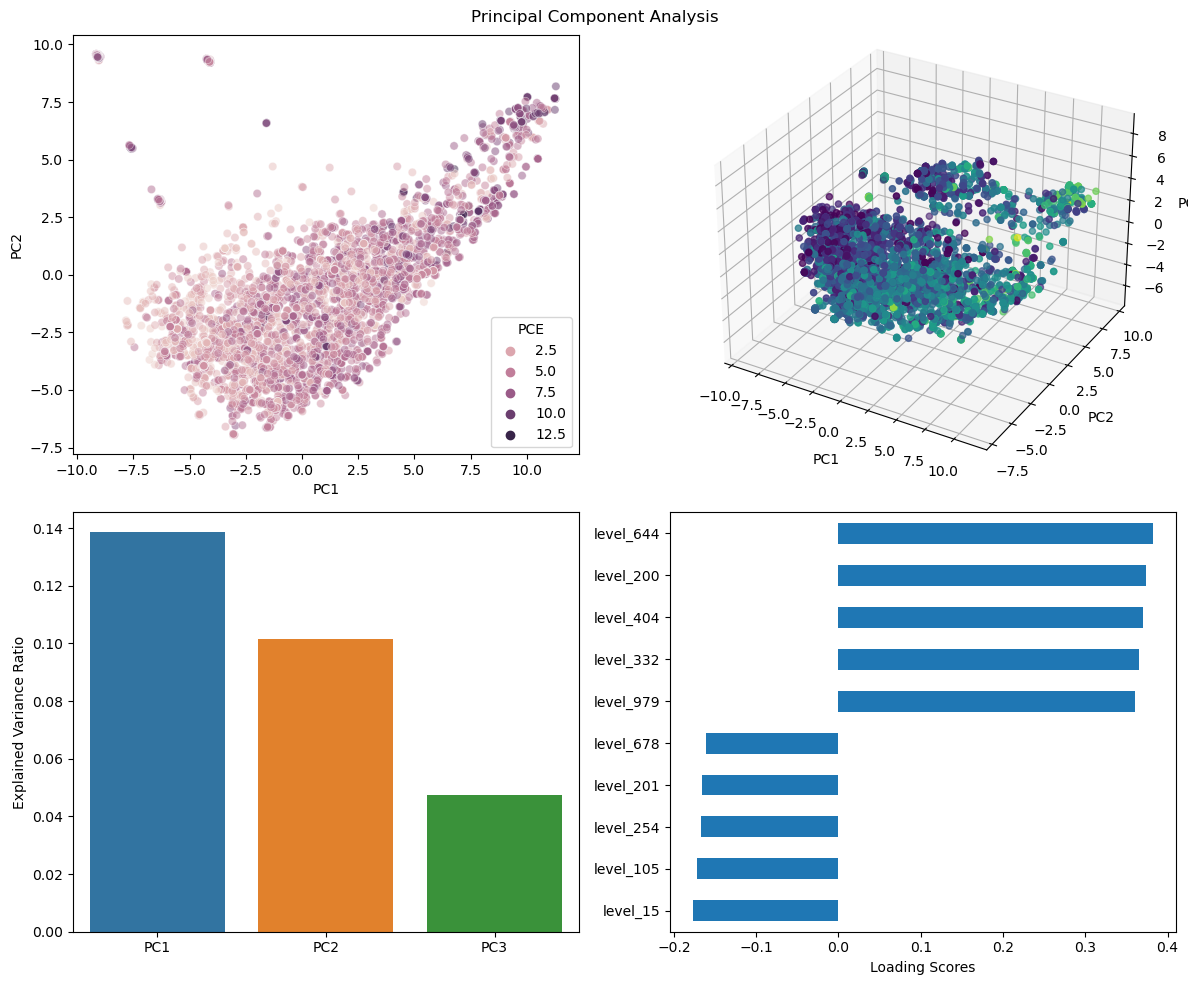

In [9]:
component_names = ["PC1", "PC2", "PC3"]

pca = PCA(n_components=3)

pca.fit(descriptors)

descriptor_pca = pd.concat([pd.DataFrame(data=pca.fit_transform(descriptors), columns=component_names), pce], axis=1)

my_funcs.pca_dashboard(original_data=descriptors, pca_data= descriptor_pca, pca=pca, hue="PCE", continuous=True)

### OPTICS Clustering

In [15]:
descriptors.dtypes

level_1                                       int64
level_2                                       int64
level_3                                       int64
level_4                                       int64
level_5                                       int64
                                              ...  
Co-adsorbent Conc. (mM)_(3934.333, 4426.0]    int64
CoSensCluster_0                               int64
CoSensCluster_1                               int64
CoSensCluster_2                               int64
CoSensCluster_None                            int64
Length: 1144, dtype: object

In [39]:
optics = OPTICS(min_samples=35, metric='jaccard', xi=0.005)

optics.fit(descriptors.values)

space = np.arange(len(descriptors))
reachability = optics.reachability_[optics.ordering_]
labels = [str(x) for x in optics.labels_[optics.ordering_]]

reachability_df = pd.DataFrame.from_dict({"Item_Index": space, "Reachability (epsilon distance)": reachability, "Cluster": labels})
reachability_df[1:]

c:\Users\clarkep\AppData\Local\anaconda3\envs\my-rdkit-env\Lib\site-packages\sklearn\cluster\_optics.py:319: DataConversionWarning: Data will be converted to boolean for metric jaccard, to avoid this warning, you may convert the data prior to calling fit.
  warnings.warn(msg, DataConversionWarning)


,Item_Index,Reachability (epsilon distance),Cluster
1,1,0.450570,-1
2,2,0.412141,-1
3,3,0.412141,-1
4,4,0.366589,-1
5,5,0.366589,-1
...,...,...,...
4421,4421,0.617188,-1
4422,4422,0.625387,-1
4423,4423,0.626335,-1
4424,4424,0.630435,-1


<Axes: xlabel='Item_Index', ylabel='Reachability (epsilon distance)'>

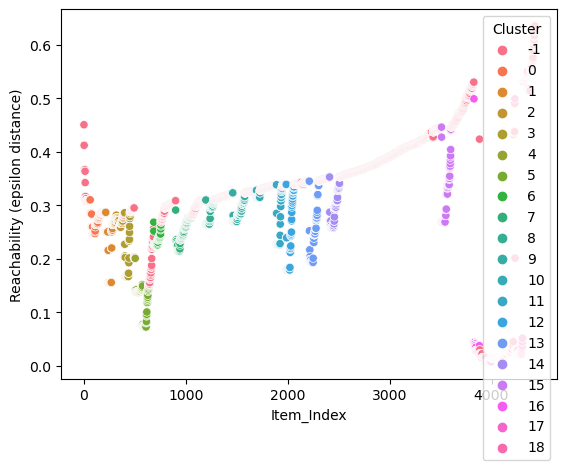

In [40]:
sns.scatterplot(data=reachability_df[1:], x="Item_Index", y="Reachability (epsilon distance)", hue="Cluster")

<Axes: xlabel='PC1', ylabel='PC2'>

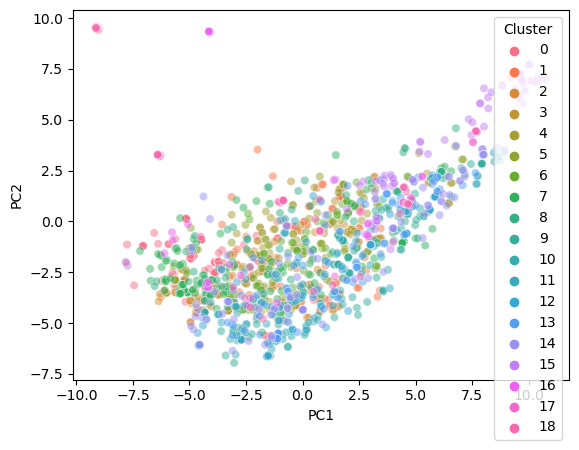

In [41]:
descriptor_pca_optics = pd.concat([descriptor_pca, reachability_df["Cluster"]], axis=1)

sns.scatterplot(data=descriptor_pca_optics.loc[descriptor_pca_optics["Cluster"] != "-1"], x="PC1", y="PC2", hue="Cluster", alpha=0.5)